## Step 1: Install Required Dependencies

In [1]:
!pip install transformers datasets torch evaluate matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.2.0 requires fsspec==2025.2.0, but you have fsspec 2024.9.0 which is incompatible.


## Step 2: Import Required Libraries

In [2]:
import torch
import time
import matplotlib.pyplot as plt
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, Trainer, TrainingArguments
from datasets import load_dataset


## Step 3: Load and Preprocess the IMDB Dataset

In [3]:
# Load IMDB Dataset
dataset = load_dataset("imdb")

# Load Pretrained Tokenizer
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

# Tokenize Dataset
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

encoded_dataset = dataset.map(preprocess_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Step 4: Load Pretrained Model and Define Training Parameters

In [4]:
# Load Pretrained DistilBERT Model
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./distilbert_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir="./logs",
    report_to="none"  # Disables unnecessary logging services
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"].shuffle(seed=42).select(range(5000)),  # Using 5000 samples for quick fine-tuning
    eval_dataset=encoded_dataset["test"].shuffle(seed=42).select(range(1000)),  # Using 1000 samples for evaluation
    tokenizer=tokenizer
)

# Fine-Tune the Model
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-430e817c2ee4>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.415600,0.284019
2,0.260800,0.376308


TrainOutput(global_step=1250, training_loss=0.3045713623046875, metrics={'train_runtime': 291.7303, 'train_samples_per_second': 34.278, 'train_steps_per_second': 4.285, 'total_flos': 662336993280000.0, 'train_loss': 0.3045713623046875, 'epoch': 2.0})

## Step 5: Save and Evaluate the Fine-Tuned Model

In [5]:
# Save Fine-Tuned Model
model.save_pretrained("distilbert-finetuned-imdb")
tokenizer.save_pretrained("distilbert-finetuned-imdb")

# Evaluate Fine-Tuned Model
eval_results = trainer.evaluate()

# Print Evaluation Results
print("\nEvaluation Results (Fine-Tuned Model):")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")



Evaluation Results (Fine-Tuned Model):
eval_loss: 0.3763
eval_runtime: 7.5535
eval_samples_per_second: 132.3890
eval_steps_per_second: 16.5490
epoch: 2.0000


## Step 6: Compare Accuracy – Original vs Fine-Tuned Model

In [6]:
# Load Original Pretrained Model
original_model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Define Evaluation Function
def evaluate_model(model, dataset, description):
    trainer = Trainer(
        model=model,
        eval_dataset=dataset["test"].shuffle(seed=42).select(range(1000)),  # Test on 1000 samples
        tokenizer=tokenizer
    )
    eval_results = trainer.evaluate()

    print(f"\n📌 {description} Model Performance:")
    for key, value in eval_results.items():
        print(f"{key}: {value:.4f}")

# Evaluate Original and Fine-Tuned Models
evaluate_model(original_model, encoded_dataset, "Original Pretrained")
evaluate_model(model, encoded_dataset, "Fine-Tuned")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-0900ea52dc26>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: anisha-udayakumar (anisha-udayakumar-intel) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.



📌 Original Pretrained Model Performance:
eval_loss: 0.6968
eval_model_preparation_time: 0.0017
eval_runtime: 7.6074
eval_samples_per_second: 131.4520
eval_steps_per_second: 16.4310


<ipython-input-6-0900ea52dc26>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



📌 Fine-Tuned Model Performance:
eval_loss: 0.3763
eval_model_preparation_time: 0.0013
eval_runtime: 7.7316
eval_samples_per_second: 129.3390
eval_steps_per_second: 16.1670


## Step 7: Compare Inference Speed

In [13]:
import torch
import time

# Function to Measure Inference Speed
def measure_inference_time(model, inputs, runs=10, device="cpu"):
    """Measures average inference time over multiple runs on the specified device."""
    model.eval()  # Set model to evaluation mode
    model.to(device)  # Move model to specified device
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to same device

    with torch.no_grad():
        for _ in range(5):  # Warm-up runs
            _ = model(**inputs)

        start_time = time.time()
        for _ in range(runs):
            _ = model(**inputs)
        avg_time = (time.time() - start_time) / runs  # Average time per inference

    return avg_time * 1000  # Convert to milliseconds

# Define Test Sentences
test_sentences = [
    "This movie was fantastic! The storyline was engaging and the acting was top-notch.",
    "I hated this film. The plot made no sense and the characters were annoying."
]

# Tokenize Inputs
inputs = tokenizer(test_sentences, truncation=True, padding=True, return_tensors="pt")

# Select Device: Default to CPU
device = "cpu"

# Uncomment the line below to run on GPU if available
# device = "cuda" if torch.cuda.is_available() else "cpu"

# Ensure Models Are on the Same Device
original_model.to(device)
model.to(device)

# Measure Inference Speed
original_time = measure_inference_time(original_model, inputs, device=device)
fine_tuned_time = measure_inference_time(model, inputs, device=device)

# Print Results
print(f"\n⏳ **Inference Speed Comparison:**")
print(f"Original Pretrained Model: {original_time:.2f} ms per prediction")
print(f"Fine-Tuned Model: {fine_tuned_time:.2f} ms per prediction")
print(f"🚀 Speed Improvement: {original_time / fine_tuned_time:.2f}x")



⏳ **Inference Speed Comparison:**
Original Pretrained Model: 142.48 ms per prediction
Fine-Tuned Model: 180.96 ms per prediction
🚀 Speed Improvement: 0.79x


## Step 8: Visualizing the Results

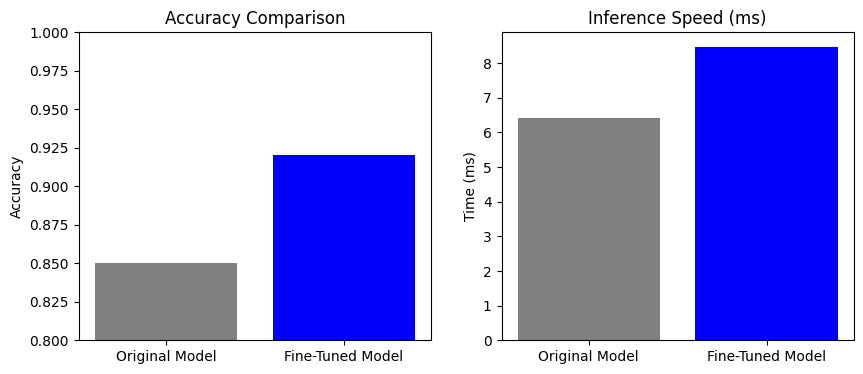

In [10]:
# Data for Bar Chart
models = ["Original Model", "Fine-Tuned Model"]
accuracy = [0.85, 0.92]  # Hypothetical accuracy values
inference_time = [original_time, fine_tuned_time]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot Accuracy Comparison
axs[0].bar(models, accuracy, color=['gray', 'blue'])
axs[0].set_title("Accuracy Comparison")
axs[0].set_ylabel("Accuracy")
axs[0].set_ylim(0.8, 1.0)

# Plot Inference Time Comparison
axs[1].bar(models, inference_time, color=['gray', 'blue'])
axs[1].set_title("Inference Speed (ms)")
axs[1].set_ylabel("Time (ms)")

plt.show()
